In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import cdist
from os import listdir
from os.path import isfile, join

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import get_T_inds, plot_FP_jitter, plot_N, TDR_axes, out_axes, make_FP_axs
from tools_lnd import make_axes, same_stim_trial, generate_Beta_epoch, take_names, comp_eig_decomp
from tools_lnd import make_h_trial_rule, get_model_params, gen_trials_from_model_dir, gen_X_from_model_dir

In [331]:
model_n = 0
task_list = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
#              'dm1', 'dm2', 'contextdm1', 'contextdm2', 'multidm',
             'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
             'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

task_list = ['fdgo', 'fdanti']#,'delaygo', 'delayanti']

rule = task_list[0]
which_net = 'l2w0001'
fldr = 'single_tasks'#'single_tasks'#str(len(task_list))+'_tasks'#
supp = []#'long_train'

if fldr != 'single_tasks':
    s = '_'
    rule_trains_str = s.join(task_list)
    file_spec = os.path.join(fldr,which_net+s+rule_trains_str)
elif fldr == 'single_tasks':
    rule_trains_str = task_list[0]
    file_spec = os.path.join(fldr,which_net,rule_trains_str)
# elif fldr == '15_tasks':
#     s = '_'
#     rule_trains_str = s.join(task_list)
#     file_spec = os.path.join(fldr,'1024_n_rnn/l2_w6_h7'+ rule_trains_str) 
else:
    file_spec = which_net
    
dir_specific_all = os.path.join(p,'data/rnn/multitask/',net,'crystals','softplus',file_spec)#,supp)
m = os.path.join(dir_specific_all,str(model_n))
# h_all,trial_all,tasks_all = make_h_trial_rule(m,mode = 'test',noise_on = False)

figpath = os.path.join(p,'code','overleaf','multitask-nets','v1_figs','figure3')
if not os.path.exists(figpath):
    os.makedirs(figpath)

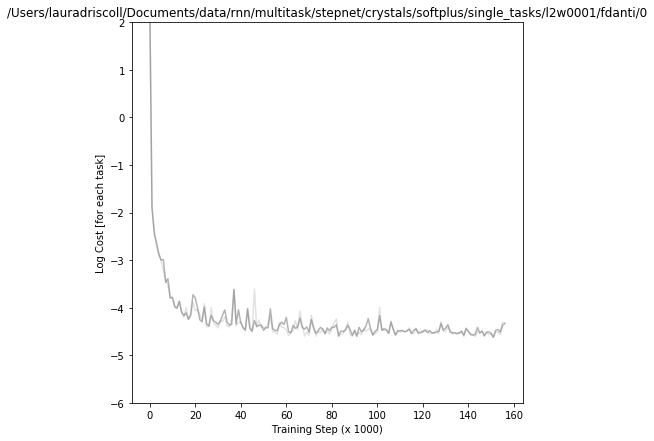

In [332]:
fig = plt.figure(figsize=(7, 7))
cmap=plt.get_cmap('Greys')


for r in range(len(task_list)):
    if fldr != 'single_tasks':
        s = '_'
        rule_trains_str = s.join(task_list)
        file_spec = os.path.join(fldr,which_net+s+rule_trains_str)
#         m = '/Users/lauradriscoll/Documents/code/multitask-nets/stepnet/data/crystals/softplus/15_tasks/512_n_rnn/l2_w6_h7fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/'
        dir_specific_all = os.path.join(p,'data/rnn/multitask/',net,'crystals','softplus',file_spec)
        m = os.path.join(dir_specific_all,str(model_n))
        fname = os.path.join(m, 'log.json')
    else:
        rule_trains_str = task_list[r]
        file_spec = os.path.join(fldr,which_net,rule_trains_str)
        dir_specific_all = os.path.join(p,'data/rnn/multitask/',net,'crystals','softplus',file_spec)
        m = os.path.join(dir_specific_all,str(model_n))
        fname = os.path.join(m, 'log.json')
    with open(fname, 'r') as f:
        log_all = json.load(f)
        c = cmap((r+1)/(len(task_list)+1))
        ax = fig.add_subplot(1,1,1)
        x = np.log(log_all['cost_'+task_list[r]])
        plt.plot(x,'-',c = c,alpha = .5)
    
ax.set_xlabel('Training Step (x 1000)')
ax.set_ylabel('Log Cost [for each task]')
plt.ylim([-6,2])
# plt.xlim([150,250])
    
plt.title(m)
plt.show()    

In [333]:
task_list = ['fdgo','fdanti']
num_fps = {}
num_fps['flat'] = []
n_models = 1
cmap = plt.get_cmap('Set1')
theta_list = [0,0]
epoch_list = ['stim1','go1']
exclude_unstable = False
unique_limit = 1
for epoch in epoch_list:
    num_fps[epoch] = []

for ri in range(len(task_list)):
    
    rule_in = task_list[ri]
    
    for model_n in range(n_models):

        if fldr != 'single_tasks':
            file_spec = os.path.join(fldr,which_net+'_'+rule_trains_str)
        else:
            file_spec = os.path.join(fldr,which_net,rule_in)

        dir_specific_all = os.path.join(p,'data/rnn/multitask/',net,'crystals','softplus',file_spec)
        m_all = os.path.join(dir_specific_all,str(model_n))
        f_path = os.path.join(m_all,'tf_fixed_pts_all_init',rule_in)
        all_files = [f for f in listdir(f_path) if isfile(join(f_path, f))]
        
        for ei in range(len(epoch_list)):
            
            epoch = epoch_list[ei]
            
            epoch_files = [f for f in all_files if f[0]==epoch[0]]
            
            D_use = make_axes(m_all,rule_in,epoch)

            for epoch_file in epoch_files:

                f = os.path.join(f_path,epoch_file)
                fp_struct = np.load(f)
                
                if exclude_unstable:
                    eig_decomps = comp_eig_decomp(fp_struct['J_xstar'])
                    keep = [np.max(eig_decomps[s]['evals'].real)<1 for s in range(np.shape(eig_decomps)[0])]
                    q = fp_struct['qstar']<.0001
                    both = [keep[s]&q[s] for s in range(len(q))]
                    fps = fp_struct['xstar'][both,:]
                else:
                    fps = fp_struct['xstar']

                X = euclidean_distances(fps)
                
#                 K_max = np.shape(X)[0] 
#                 tril = np.tril(X,-1)
                
#                 if (tril[tril!=0]<unique_limit).any():
                    
#                     if (X>unique_limit).any():
#                         distortions = []

#                         K = range(1,np.min((K_max,31)))
#                         for k in K:
#                             kmeanModel = KMeans(n_clusters=k).fit(X)
#                             kmeanModel.fit(X)
#                             distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
                        
#                         if np.sum(-np.diff(distortions)<.1)>0:
#                             n_fps = np.min(np.where(-np.diff(distortions)<.1))+1
#                         else:
#                             n_fps = K_max
                        
#                     else:
#                         n_fps = 1
                        
#                 else:
#                     n_fps = K_max
                   
                fp_unique = np.zeros((len(X)), dtype=bool)
                if len(X)>2:
                
                    fp_unique[0] = True
                    for s in range(1,len(X)):
                        min_dist = np.min(X[s,np.arange(len(X))!=s])
                        if min_dist>unique_limit:
                            fp_unique[s] = True
                        else:
                            min_dist = np.min(X[s,fp_unique])
                            if min_dist>unique_limit:
                                fp_unique[s] = True
                                
                    n_fps = sum(fp_unique)
                elif len(X)==1:
                    n_fps=1
                    fp_unique[0] = True
                elif X[1,0]>unique_limit:
                    n_fps=2
                    fp_unique[0] = True
                    fp_unique[1] = True
                else:
                    n_fps=1
                    fp_unique[0] = True
                    
                ## view fps and cluster number   
#                 if n_fps>1:
#                     pca = PCA(n_components = 2)
#                     fp_pca = pca.fit_transform(fp_struct['xstar'])
#                     D_use = pca.components_.T
#                     exclude_fp = np.dot(fp_struct['xstar'],D_use)
#                     if exclude_unstable:
#                         keep_fp = np.dot(fp_struct['xstar'][keep,:],D_use)

#                     plt.subplot(1,3,1)
#                     plt.plot(exclude_fp[:,0],exclude_fp[:,1],'or')
#                     if exclude_unstable:
#                         plt.plot(keep_fp[:,0],keep_fp[:,1],'ok')
#                     plt.title(int(n_fps))

#                     plt.subplot(1,3,2)
#                     plt.imshow(X,vmax = .002)
#                     plt.colorbar()

#                     plt.subplot(1,3,3)
#                     plt.imshow(X[fp_unique,:])
#                     plt.colorbar()
#                     plt.show()
#                 if n_fps==1:
        
#                     if rule_in[-2:]=='go':
#                         temp = re.findall(r'\d+', epoch_file) 
#                         res = list(map(int, temp))
#                         t_num = int(80*res[1]/360)
#                     else:
#                         temp = re.findall(r'\d+', epoch_file) 
#                         res = list(map(int, temp))
#                         t_num = int(((80*res[1]/360)-40)%80)
                    
#                     eig_decomps = comp_eig_decomp(fp_struct['J_xstar'])
#                     sorted_fps = fp_struct['xstar']
#                     fp_inds = range(len(sorted_fps))
#                     plot_FP_jitter(m_all,D_use,rule_in,t_num,epoch,sorted_fps,fp_inds,eig_decomps,[rule_in,],
#                                rand_step_coef = .1, al = .3, linestyle = '-', n_steps = 10, 
#                                    n_jit = 20,c_master = 'k')
#                     plt.title(str(n_fps))
#                     plt.show()
#                     print(epoch_file)
#                     print(fp_struct['qstar'])
#                     print([np.max(eig_decomps[s]['evals'].real)<1 for s in range(np.shape(eig_decomps)[0])])
                

                if len(num_fps[epoch]) == 0:
                    num_fps[epoch] = [int(n_fps),]
                else:
                    num_fps[epoch] = np.concatenate((num_fps[epoch],[int(n_fps),]),axis = 0)

                if len(num_fps['flat']) == 0:
                    num_fps['flat'] = [int(n_fps),]
                else:
                    num_fps['flat'] = np.concatenate((num_fps['flat'],[int(n_fps),]),axis = 0)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/single_tasks/l2w0001/fdgo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/single_tasks/l2w0001/fdgo/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/laura

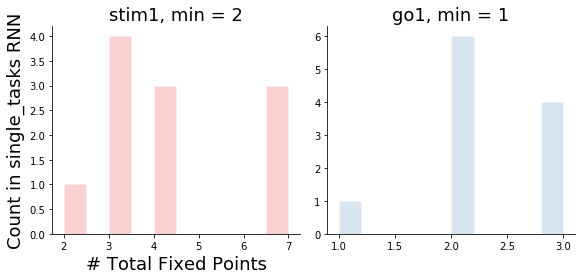

In [334]:
fig = plt.figure(figsize=(12,4),tight_layout=True,facecolor='white')

for ei in range(len(epoch_list)):
    epoch = epoch_list[ei]
    ax = plt.subplot(1,3,ei+1)
    plt.hist(num_fps[epoch], alpha = .2, color = cmap((ei+1)/10),edgecolor='w')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    if ei==0:
        if exclude_unstable:
            plt.xlabel('# Stable Fixed Points', fontsize = 18)
        else:
            plt.xlabel('# Total Fixed Points', fontsize = 18)
        plt.ylabel('Count in '+fldr+' RNN', fontsize = 18)
        
    plt.title(epoch+', min = '+str(np.min(num_fps[epoch])), fontsize = 18)
        
figname = 'ex_unstable_'+str(exclude_unstable)+'_'+fldr+'_'+which_net+'hist_num_fps.pdf'
plt.savefig(os.path.join(figpath,figname))
plt.show()

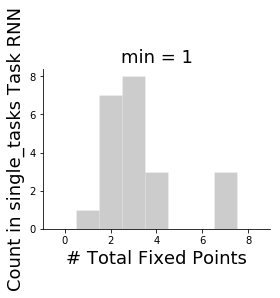

In [335]:
fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')
ax = plt.subplot(111)

# plt.hist(np.sort(num_fps['flat']), alpha = .2, color = 'k',edgecolor='w')

plt.hist(num_fps['flat'],np.linspace(-.5, max(num_fps['flat'])+1.5, max(num_fps['flat'])+3),
         alpha = .2, color = 'k',edgecolor='w')

if exclude_unstable:
    plt.xlabel('# Stable Fixed Points', fontsize = 18)
else:
    plt.xlabel('# Total Fixed Points', fontsize = 18)
plt.ylabel('Count in '+fldr+' Task RNN', fontsize = 18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title('min = '+str(np.min(num_fps[epoch])), fontsize = 18)

# xtix = [int(x) for x in range(max(num_fps['flat'])+2)]
# plt.xticks(xtix)
# plt.yticks(range(int(np.max(ax.get_yticks())+1)))

figname = 'ex_unstable_'+str(exclude_unstable)+'_'+fldr+'_'+which_net+'hist_num_fps.pdf'
plt.savefig(os.path.join(figpath,figname))
plt.show()